In [3]:
# 方式一
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['deer', 'frog', 'dog', 'ship']


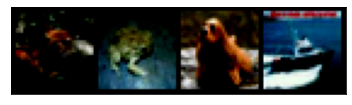

In [7]:
from torchvision.utils import make_grid

def imshow(img):   
    #figsize显示图片的长宽 
    fig, ax = plt.subplots(figsize=(6, 6))
    #不显示坐标轴
    ax.set_xticks([]); ax.set_yticks([])
    #用图像做一个网格，默认每行是8，可利用nrow调整
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0)) 

#将trainloader变为可迭代的对象
dataiter = iter(trainloader) 
#获得随机的训练图像
images, labels = dataiter.next()

# show images
imshow(images)
#打印对应的分类标签
print([trainset.classes[i] for i in labels])

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):#固定写法
        super(Net, self).__init__() #固定写法
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
#定义迭代器和优化函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # 从0开始为trainloader编号
        '''
        seq = ['one', 'two', 'three']
        for i, element in enumerate(seq):
            print i, element
        ... 
        0 one
        1 two
        2 three
        '''
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #训练流程：优化器清0，计算损失，反馈，记录参数
        
        # zero the parameter gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()
        running_loss = running_loss + loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.133
[1,  4000] loss: 1.815
[1,  6000] loss: 1.681
[1,  8000] loss: 1.618
[1, 10000] loss: 1.555
[1, 12000] loss: 1.507
[2,  2000] loss: 1.445
[2,  4000] loss: 1.424
[2,  6000] loss: 1.395
[2,  8000] loss: 1.372
[2, 10000] loss: 1.327
[2, 12000] loss: 1.317
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'ship', 'ship', 'airplane']


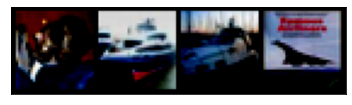

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(images)
print([testset.classes[i] for i in labels])

In [13]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

predicted=[testset.classes[j] for j in predicted]
print(predicted)

['cat', 'ship', 'ship', 'airplane']


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)        
        #total += labels.size(0)
        '''
        print(images.size())
        print(predicted)
        print(labels)
        print((predicted == labels).sum().item()) #解释见https://www.cnblogs.com/wanghui-garcia/p/10558819.html
        '''
        correct = correct + (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [16]:
class_correct = list(0 for i in range(10)) # [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class_total = list(0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        #c = (predicted == labels)
        c = (predicted == labels).squeeze()
        #print(c)
        for i in range(4): # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]
            class_correct[label] = class_correct[label] + c[i].item() # c[i].item()为True or Flase, 1 + True = 2; 1 + False = 1
            class_total[label] = class_total[label] + 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 71 %
Accuracy of  bird : 36 %
Accuracy of   cat : 39 %
Accuracy of  deer : 41 %
Accuracy of   dog : 29 %
Accuracy of  frog : 82 %
Accuracy of horse : 54 %
Accuracy of  ship : 65 %
Accuracy of truck : 61 %
